In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import datetime
import emoji
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [40]:
# read raw csv file
df = pd.read_csv('./trump_impeachment_no_country.csv')

# combine 'date' and 'time' column into one column
df['date_time'] = df[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# drop records with tweets that are non-english
df = df.drop(df[df.language != 'en'].index)

# drop unnecessary columns
df.drop(['quote_url', 'thumbnail', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'cashtags', 'timezone', 'created_at', 'retweet', 'near', 'urls', 'photos', 'replies_count', 'retweets_count', 'link', 'video', 'reply_to', 'place', 'conversation_id', 'name', 'username', 'mentions', 'hashtags', 'language', 'date', 'time'], axis='columns', inplace=True)

# rename 'tweet' column to 'comment' to standardise column names
df.rename(columns={'tweet':'comment', 'id':'comment_id'}, inplace=True)

# insert 'platform' column, and label it 'twitter'
df.insert(2, 'platform', 'twitter')

# rearrange columns to standardise
cols = list(df.columns)
cols = cols[:3] + [cols[5]] + [cols[4]] + [cols[3]]
df2 = df[cols]
df2


,comment_id,user_id,platform,date_time,likes_count,comment
0,1361827317136445442,1103704740809109504,twitter,2021-02-17 07:58:28,0,Will not being convicted end up spurring more ...
1,1361827186399793152,561690193,twitter,2021-02-17 07:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ..."
2,1361826976781197317,1103704740809109504,twitter,2021-02-17 07:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...
3,1361826947316219908,1103704740809109504,twitter,2021-02-17 07:57:00,0,@DrJasonJohnson Will not being convicted end u...
4,1361826793091719171,1103704740809109504,twitter,2021-02-17 07:56:23,0,@davidplouffe Will not being convicted end up ...
...,...,...,...,...,...,...
100079,1354824640938586112,1281704313727922178,twitter,2021-01-29 00:12:20,0,@RoyBlunt As a Mo. citizen I am asking that yo...
100080,1354824634248568834,19553409,twitter,2021-01-29 00:12:18,140,57% of Voters Say Trump Impeachment Will Furth...
100081,1354824563301830656,709378458112172032,twitter,2021-01-29 00:12:01,2,👀 Look at supporters of Sedition? Littl’ Lyin’...
100082,1354824463951360000,1344885199377723392,twitter,2021-01-29 00:11:38,1,# New York Lied about Covid Deaths # Californ...


In [41]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93416 entries, 0 to 100083
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment_id   93416 non-null  int64 
 1   user_id      93416 non-null  int64 
 2   platform     93416 non-null  object
 3   date_time    93416 non-null  object
 4   likes_count  93416 non-null  int64 
 5   comment      93416 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.0+ MB


In [82]:
# conduct basic text-preprocessing on 'comment' column

# initialise lists for later
comment_no_emoji_list = []
comment_processed_list = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
# stopwords_list += ['donald', 'trump', 'impeachment'] #additional stopwords customised based on context

# iterate through every comment in the dataframe
for text in df2['comment']:
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text = emoji_pattern.sub(r'', text) # remove emojis
    text_tokenised = word_tokenize(text) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_no_emoji_list.append(text)
    comment_processed_list.append(text_stopremoved)

# create new columns
df2['comment_no_emoji'] = comment_no_emoji_list
df2['comment_processed'] = comment_processed_list
df3 = df2
df3.head()

,comment_id,user_id,platform,date_time,likes_count,comment,comment_no_emoji,comment_processed
0,1361827317136445442,1103704740809109504,twitter,2021-02-17 07:58:28,0,Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him. @danielsgoldman @NicolleDWallace,Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,"[convicted, end, spurring, less, actions, trump, impeachment, may, better]"
1,1361827186399793152,561690193,twitter,2021-02-17 07:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, Gets Up, and Walks Away https://t.co/oeUFuHox7L","Trump Impeachment Attorney SLAMS News Anchor, Gets Up, and Walks Away","[trump, impeachment, attorney, slams, news, anchor, gets, walks, away]"
2,1361826976781197317,1103704740809109504,twitter,2021-02-17 07:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,"[convicted, end, spurring, less, actions, trump, impeachment, may, better]"
3,1361826947316219908,1103704740809109504,twitter,2021-02-17 07:57:00,0,@DrJasonJohnson Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,"[convicted, end, spurring, less, actions, trump, impeachment, may, better]"
4,1361826793091719171,1103704740809109504,twitter,2021-02-17 07:56:23,0,@davidplouffe Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,Will not being convicted end up spurring more or less actions against trump. Impeachment may have been better for him.,"[convicted, end, spurring, less, actions, trump, impeachment, may, better]"


In [80]:
# creating wordcloud

# create list of words
wordcloud_words = []
for wordlist in df3['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(word)

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[50:200]

'orney slams news anchor gets walks away convicted end spurring less actions may better convicted end spurring less actions may better convicted end sp'

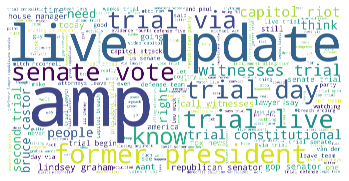

In [81]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("trump_impeachment_twitter2.png")

In [ ]:
# vader sentiment analysis

def vader_compound_score(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

df3['vader_score'] = df3['comment_no_emoji'].apply(vader_compound_score) 

In [ ]:
df3.head()

In [ ]:
df3.to_csv("trump_impeachment_no_country_processed.csv")